## Dataset Preparation 

In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(root='point_machine_images', transform=train_transform)

# Split dataset (80% train, 20% val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply different transform to validation
val_dataset.dataset.transform = val_transform

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Verify
print(f"Total classes: {len(full_dataset.classes)}")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Total classes: 16
Train samples: 1280
Validation samples: 320


## Model Definition 

In [2]:
import torch.nn as nn
import torchvision.models as models

class PointMachineClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.base_model(x)

# Initialize model
model = PointMachineClassifier(num_classes=len(full_dataset.classes))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training Loop 

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        scheduler.step()
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                
        val_loss = val_loss / len(val_dataset)
        val_acc = val_corrects.double() / len(val_dataset)
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n')
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    print(f'Best val Acc: {best_acc:.4f}')
    return model

# Start training
model = train_model(model, criterion, optimizer, scheduler)

Epoch 1/5
----------
Train Loss: 0.7034 Acc: 0.7961
Val Loss: 2.1664 Acc: 0.5250

Epoch 2/5
----------
Train Loss: 0.0520 Acc: 0.9891
Val Loss: 0.1988 Acc: 0.9406

Epoch 3/5
----------
Train Loss: 0.0444 Acc: 0.9906
Val Loss: 0.1570 Acc: 0.9531

Epoch 4/5
----------
Train Loss: 0.0322 Acc: 0.9930
Val Loss: 0.1380 Acc: 0.9531

Epoch 5/5
----------
Train Loss: 0.0236 Acc: 0.9961
Val Loss: 0.5378 Acc: 0.8562

Best val Acc: 0.9531


## Evaluation 

              precision    recall  f1-score   support

     129_130       1.00      0.97      0.98        30
     159_160       0.94      1.00      0.97        15
   PT101_102       0.84      1.00      0.91        16
   PT119_120       0.93      0.87      0.90        15
  PT_101_102       0.92      0.85      0.88        13
PT_101___102       0.86      1.00      0.92        18
  PT_103_104       0.93      0.96      0.94        26
  PT_109_110       0.93      1.00      0.96        26
PT_111___112       1.00      0.95      0.97        19
  PT_119_120       1.00      1.00      1.00        26
PT_119___120       0.88      1.00      0.94        15
  PT_121_122       1.00      1.00      1.00        22
  PT_129_130       1.00      0.72      0.84        18
PT_135___136       1.00      0.95      0.97        20
PT_157___158       1.00      0.92      0.96        24
PT_189___190       1.00      1.00      1.00        17

    accuracy                           0.95       320
   macro avg       0.95   

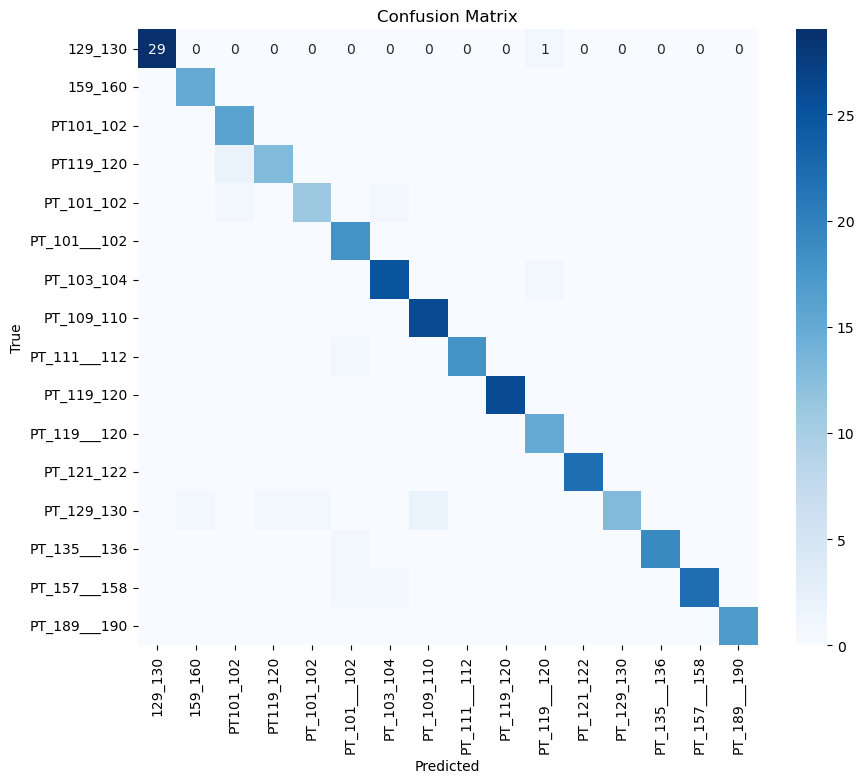

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=full_dataset.classes, 
                yticklabels=full_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
evaluate_model(model, val_loader)